Entry: /usr/local/share/pynq-venv/lib/python3.8/site-packages/ipykernel_launcher.py
System argument(s): 3
Start of "/usr/local/share/pynq-venv/lib/python3.8/site-packages/ipykernel_launcher.py"
#-----------------ORIGIANL PIC--------------------#


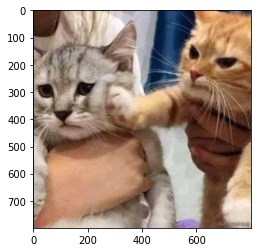

#-----------------READ DATA OK--------------------#
#-----------------KERNEL START--------------------#
Kernel execution time: 5.128326654434204 s
#------------------KERNEL END---------------------#
BER =  1.5298615456821028 %


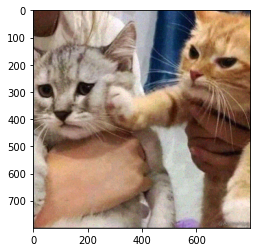

#---------------------EXIT------------------------#


In [11]:
from __future__ import print_function

import sys
import numpy as np
from time import sleep
from time import time
from PIL import Image 
import matplotlib.pyplot as plt
import math

sys.path.append('/home/xilinx')
from pynq import Overlay
from pynq import allocate

if __name__ == "__main__":
    print("Entry:", sys.argv[0])
    print("System argument(s):", len(sys.argv))
    print("Start of \"" + sys.argv[0] + "\"")

    ol = Overlay("com_20ns.bit")
    ipcomm = ol.top_module_0

    module_id = np.array([0,2,3,4,5,6,7,8,9,10,12,13,14])
    len_module_id = len(module_id)
    len_parameter_id = [3,4,4,3,4,6,4,3,5,4,3,1,1] # The number of parameters in each module
    parameter_sum = sum(len_parameter_id)

    qam_num = 16
    sym_num = 2
    pilot_width = 4
    CP_length = 16
    TAPS_NUM = 1
    SNR = [15]
    FFT_len = 64 
    
    RGB_val = 3
    print("#-----------------ORIGIANL PIC--------------------#")
    cat_pic = Image.open("cat_punch.jpg")
    plt.imshow(cat_pic)
    plt.show()
    cat_pic = cat_pic.rotate(270)
    cat_pic = cat_pic.transpose(Image.FLIP_LEFT_RIGHT)
    pic_array = allocate(shape=((cat_pic.size[0]*cat_pic.size[1]*3),), dtype=np.uint8)
    for inx1 in range(cat_pic.size[0]):
        for inx2 in range(cat_pic.size[1]):
                pix = cat_pic.getpixel((inx1,inx2))
                pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+0] = pix[0]
                pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+1] = pix[1]
                pic_array[(inx1)*(cat_pic.size[1])*RGB_val+(inx2)*RGB_val+2] = pix[2]
    print("#-----------------READ DATA OK--------------------#")
    
    numSamples = cat_pic.size[0]*cat_pic.size[1]*3
    input_compensate = (int)(((FFT_len-(FFT_len/pilot_width))/sym_num)-(numSamples%((FFT_len-(FFT_len/pilot_width))/sym_num)))
    data_len = numSamples + input_compensate
    total_input_num = data_len + parameter_sum + 1
    in_num_sample = parameter_sum + 1 + data_len
    out_num_sample = data_len
    
    input_buffer = allocate(shape=(in_num_sample,), dtype=np.uint64)
    output_buffer = allocate(shape=(out_num_sample,), dtype=np.uint64)
    
    BER = [0]*len(SNR)
    out_pic = allocate(shape=((cat_pic.size[0]*cat_pic.size[1]*3),), dtype=np.uint64)
    
    parameter_id = np.array([[data_len,qam_num,sym_num], # module_id = 0 pixl2sym
                            [data_len,qam_num,sym_num,pilot_width], # module_id = 2 QAM
                            [data_len,sym_num,pilot_width,CP_length], # module_id = 3 pilot insert
                            [data_len,sym_num,pilot_width], # module_id = 4 IFFT
                            [data_len,sym_num,pilot_width,CP_length], # module_id = 5 CP insert
                            [data_len,sym_num,pilot_width,CP_length,TAPS_NUM,SNR], # module_id = 6 channel
                            [data_len,sym_num,pilot_width,CP_length], # module_id = 7 CP remove
                            [data_len,sym_num,pilot_width], # module_id = 8 FFT
                            [data_len,sym_num,pilot_width,CP_length, TAPS_NUM], # module_id = 9 pilot remove
                            [data_len,qam_num,sym_num,pilot_width], # module_id = 10 deQAM
                            [data_len,qam_num,sym_num], # module_id = 12 sym2pixl
                            [total_input_num], # module_id = 13 mas2str
                            [data_len]],dtype=object) # module_id = 14 str2mas

    #-----------------parameter set--------------------#
    temp = allocate(shape=(1,), dtype=np.uint64)
    cnt_para_in = 0
    for i in range(len_module_id):
        temp[0] = module_id[i] * pow(2,16) 
        for j in range(len_parameter_id[i]):
            input_buffer[cnt_para_in+j] = temp[0]
            input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] + j
            input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] * pow(2,32)
            input_buffer[cnt_para_in+j] = input_buffer[cnt_para_in+j] + parameter_id[i][j]
        cnt_para_in = cnt_para_in+len_parameter_id[i]
    input_buffer[parameter_sum] = (pow(2,16)-1)*pow(2,48)

    #-----------------data set--------------------#
    for k in range(data_len):
        if (k<numSamples):
            input_buffer[parameter_sum+k+1] = pic_array[k]
        else:
            input_buffer[parameter_sum+k+1] = 0

    print("#-----------------KERNEL START--------------------#")
    timeKernelStart = time()
    ipcomm.write(0x10, input_buffer.device_address)
    ipcomm.write(0x1C, output_buffer.device_address)
    ipcomm.write(0x00, 0x01)
    while (ipcomm.read(0x00) & 0x4) == 0x0:
        continue
    timeKernelEnd = time()
    print("Kernel execution time: " + str(timeKernelEnd - timeKernelStart) + " s")
    print("#------------------KERNEL END---------------------#")

    ber = 0
    pixl_length = 8
    for k in range(numSamples):
        err = '{:08b}'.format(output_buffer[k]^(input_buffer[k+parameter_sum+1])).count('1')
        ber = ber + err
        out_pic[k] = output_buffer[k]
        
    BER = ber/numSamples/pixl_length*100
    print("BER = ", BER, "%")
    out_pic_matrix = out_pic.reshape(cat_pic.size[0],cat_pic.size[1],3)
    plt.imshow(out_pic_matrix)
    plt.show()
      
    print("#---------------------EXIT------------------------#")

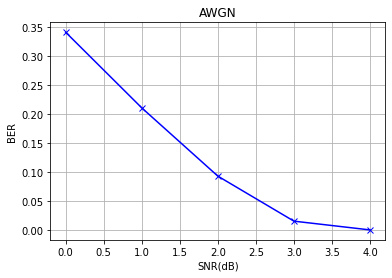

In [10]:
SNR = [0, 5, 10, 15, 20]
BER = [0.34173791458072586,0.2110691750104297,0.09312565185648728,0.015298615456821028,0.0001600307676261994] #corresponding BER 
plt.title("AWGN")
plt.xlabel("SNR(dB)") 
plt.ylabel("BER")
xSeq = range(len(SNR))
plt.plot(xSeq, BER, 'b-x')
plt.grid(True)
plt.show()